<a href="https://colab.research.google.com/github/KjetilMolnvik/MasterProject2024/blob/main/WER_AUC_Plot_Artificial_and_Natural_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
import os
import librosa

drive.mount('/content/gdrive', force_remount=True)

base_dir = "/content/gdrive/My Drive/Master_2024_audio"

Mounted at /content/gdrive


In [2]:
pip install werpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.3/46.3 kB 1.4 MB/s eta 0:00:00


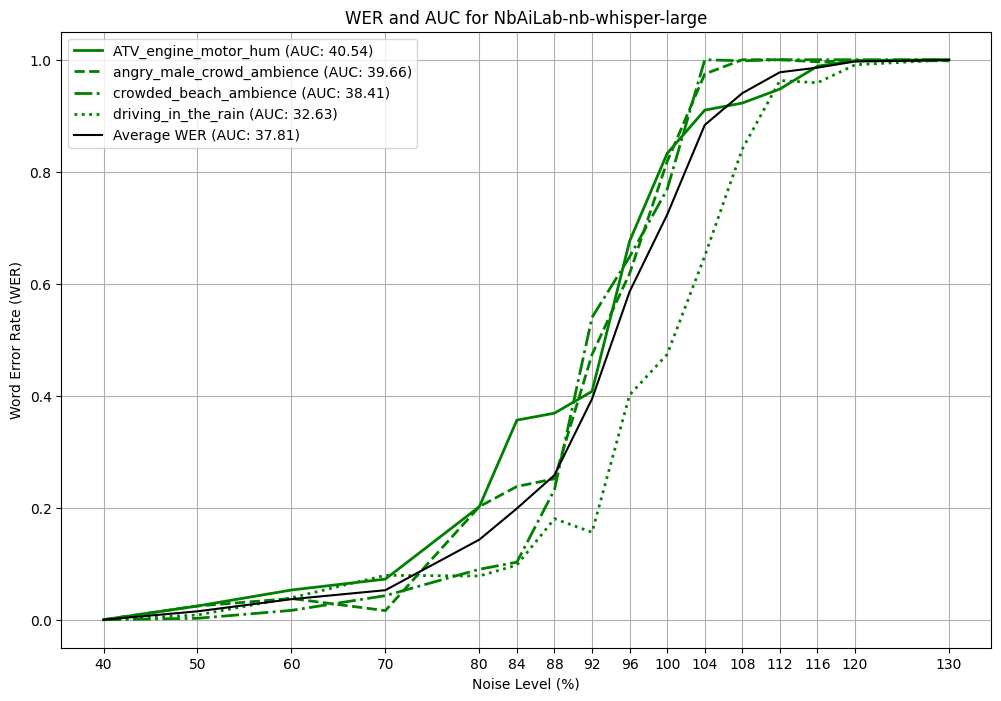

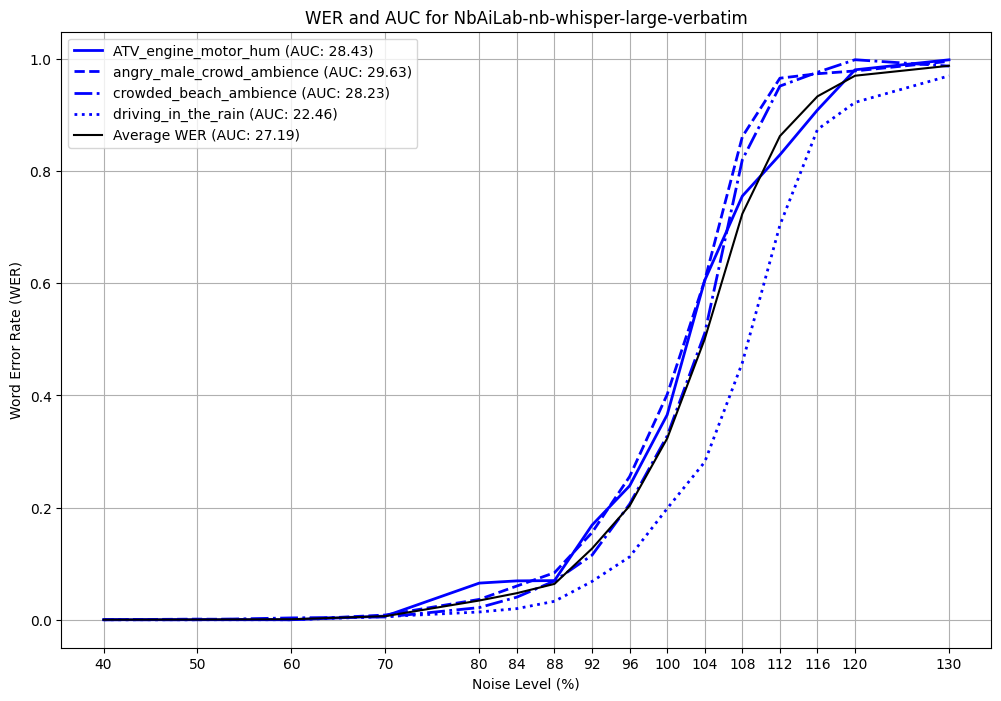

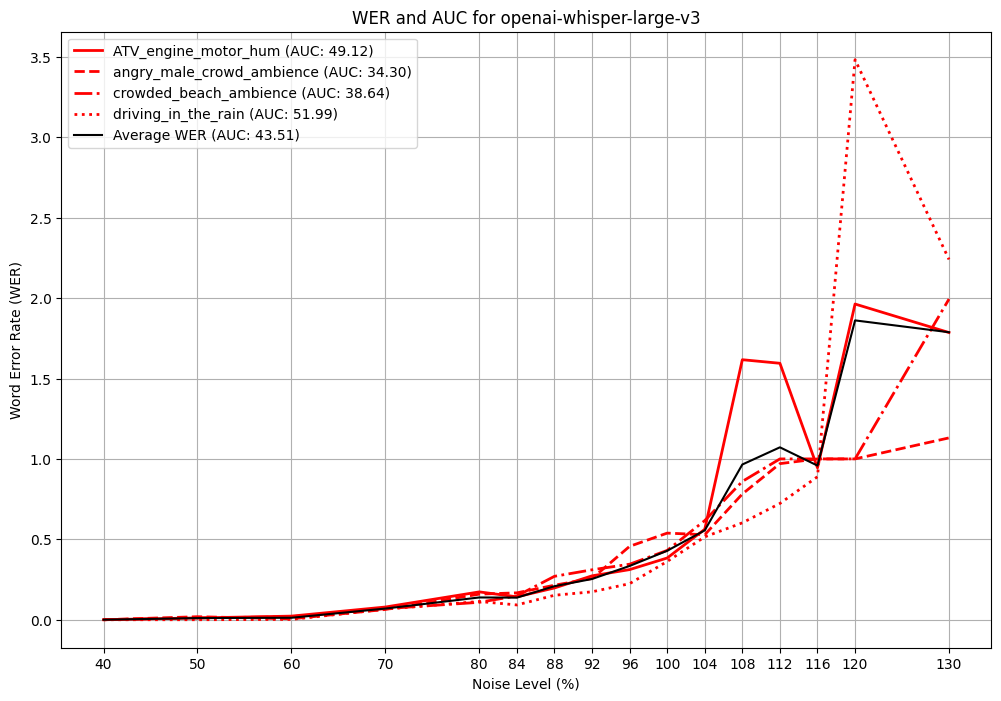

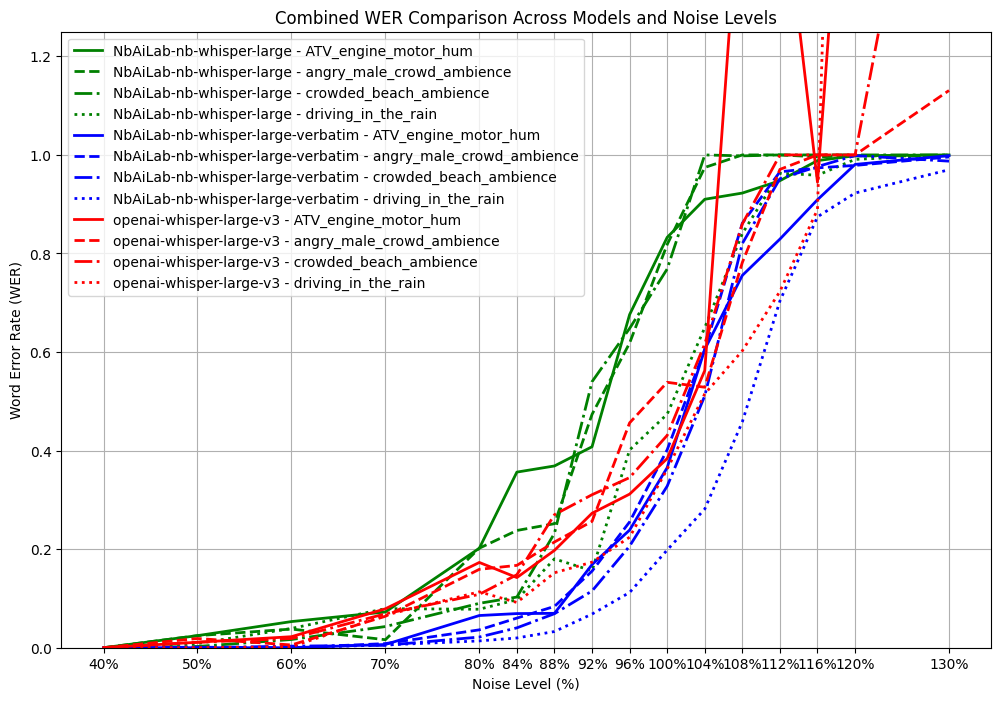

In [9]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import re
from itertools import cycle
import werpy
import csv

def find_ground_truth_text(speaker_path):
    ground_truth_files = list(speaker_path.glob("*_40%_*_transcribed.txt"))
    if not ground_truth_files:
        print(f"No ground truth file found in {speaker_path}")
        return None
    return ground_truth_files[0].read_text()

def extract_text(input_text):
    # Regex to extract the text field from a structured string representation
    match = re.search(r"AutomaticSpeechRecognitionOutput\(text='([^']+)'", input_text, re.IGNORECASE)
    if match:
        return match.group(1)
    return input_text

def custom_normalize(text):
    text = extract_text(text)
    text = text.replace('chunks=None', '').strip()
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def calculate_wer(ground_truth, transcribed):
    normalized_gt = custom_normalize(ground_truth)
    normalized_transcribed = custom_normalize(transcribed)
    return werpy.wer(normalized_gt, normalized_transcribed)

def process_transcribed_files(base_path, result_path):
    result_path.mkdir(parents=True, exist_ok=True)
    all_results = {}
    for noise_type_path in base_path.iterdir():
        if noise_type_path.is_dir() and ".ipynb_checkpoints" not in noise_type_path.parts:
            noise_type_results = {}
            for speaker_path in noise_type_path.iterdir():
                if speaker_path.is_dir() and ".ipynb_checkpoints" not in speaker_path.parts:
                    ground_truth_text = find_ground_truth_text(speaker_path)
                    if ground_truth_text is None:
                        continue
                    speaker_results = {}
                    for transcribed_file in speaker_path.glob("*.txt"):
                        if "_transcribed" in transcribed_file.stem and ".ipynb_checkpoints" not in transcribed_file.parts:
                            match = re.search(r'_(\d+)%_', transcribed_file.stem)
                            if match:
                                noise_level = int(match.group(1))
                                transcribed_text = transcribed_file.read_text()
                                error_rate = calculate_wer(ground_truth_text, transcribed_text)
                                if noise_level not in speaker_results:
                                    speaker_results[noise_level] = []
                                speaker_results[noise_level].append(error_rate)
                            else:
                                print(f"Noise level not found in filename: {transcribed_file.stem}")
                    for noise_level, wer_list in speaker_results.items():
                        avg_wer = sum(wer_list) / len(wer_list)
                        if noise_level not in noise_type_results:
                            noise_type_results[noise_level] = []
                        noise_type_results[noise_level].append(avg_wer)
            averaged_noise_type_results = {level: sum(wers) / len(wers) for level, wers in noise_type_results.items()}
            all_results[noise_type_path.name] = averaged_noise_type_results
    return all_results

def plot_combined_wer_comparison(wer_data, model_styles, line_styles):
    plt.figure(figsize=(12, 8))
    lines_cycle = cycle(line_styles)  # Create an infinite iterator that cycles through line styles

    # Collect all possible noise levels from all models to ensure uniform x-axis
    all_noise_levels = sorted(set(level for model_data in wer_data.values() for wer_values in model_data.values() for level in wer_values.keys()))
    actual_noise_levels = np.array(all_noise_levels)  # Convert to numpy array for vectorized operations

    # Plot each model's data
    for model_name, model_data in wer_data.items():
        color = model_styles[model_name]['color']
        for noise_type, wer_values in sorted(model_data.items()):
            noise_levels = sorted(wer_values.keys())
            wer_scores = [wer_values[level] for level in noise_levels]
            line_style = next(lines_cycle)  # Use the next line style from the cycle
            plt.plot(noise_levels, wer_scores, line_style, label=f"{model_name} - {noise_type}", color=color, linewidth=2)

    plt.title("Combined WER Comparison Across Models and Noise Levels")
    plt.xlabel("Noise Level (%)")
    plt.ylabel("Word Error Rate (WER)")
    plt.legend()

    # Offset to apply to the noise levels for display
    offset = 1  # Adjusting so 40% appears as -60%
    adjusted_labels = {level: f"{level * offset}%" for level in all_noise_levels}
    # Applying custom tick labels
    plt.xticks(ticks=all_noise_levels, labels=[adjusted_labels[level] for level in all_noise_levels])

    plt.ylim(0, 1.25)
    plt.grid(True)
    plt.show()



def plot_model_wer_with_auc(model_name, model_data, model_style, line_styles):
    plt.figure(figsize=(12, 8))
    color = model_style['color']
    lines_cycle = cycle(line_styles)  # Ensure cycling of line styles
    all_wer_scores = []

    # Prepare a list of all possible noise levels to standardize the plotting
    all_noise_levels = sorted(set(level for wer_values in model_data.values() for level in wer_values.keys()))
    actual_noise_levels = np.array(all_noise_levels)  # Convert to numpy array for vectorized operations

    for noise_type, wer_values in sorted(model_data.items()):
        # Ensure wer_scores align with all_noise_levels for consistent plotting
        wer_scores = [wer_values.get(level, np.nan) for level in all_noise_levels]
        all_wer_scores.append(wer_scores)
        line_style = next(lines_cycle)
        calculated_auc = np.trapz(wer_scores, all_noise_levels)  # Ensure calculation uses all_noise_levels
        plt.plot(actual_noise_levels, wer_scores, line_style, label=f"{noise_type} (AUC: {calculated_auc:.2f})", color=color, linewidth=2)

    # Calculate the average WER scores using np.nanmean to safely ignore NaN values
    if all_wer_scores:
        average_wer_scores = np.nanmean(all_wer_scores, axis=0)
        average_auc = np.trapz(average_wer_scores, all_noise_levels)
        plt.plot(actual_noise_levels, average_wer_scores, 'k-', label=f'Average WER (AUC: {average_auc:.2f})', linewidth=1.5)
    else:
        print("No data available to plot.")

    # Adjusting labels to show starting from -60%
    # Offset to apply to the noise levels
    offset = 1  # Adjusting so 40% appears as -60%
    adjusted_labels = {level: f"{level * offset}" for level in all_noise_levels}
    # Applying custom tick labels
    plt.xticks(ticks=all_noise_levels, labels=[adjusted_labels[level] for level in all_noise_levels])

    plt.title(f"WER and AUC for {model_name}")
    plt.xlabel("Noise Level (%)")
    plt.ylabel("Word Error Rate (WER)")
    plt.legend()
    plt.grid(True)
    plt.show()





def write_wer_to_csv(all_results, output_file_path):
    with open(output_file_path, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['Model Name', 'Noise Type', 'Noise Level', 'Average WER'])

        for model_name, noise_types in all_results.items():
            for noise_type, wer_levels in noise_types.items():
                for noise_level, average_wer in wer_levels.items():
                    writer.writerow([model_name, noise_type, noise_level, average_wer])


def main():
    models = [
        {"name": "NbAiLab-nb-whisper-large", "path": "/content/gdrive/My Drive/Master_2024_audio/artificially_noisy_speech/transcribed_audio/NbAiLab-nb-whisper-large"},
        {"name": "NbAiLab-nb-whisper-large-verbatim", "path": "/content/gdrive/My Drive/Master_2024_audio/artificially_noisy_speech/transcribed_audio/NbAiLab-nb-whisper-large-verbatim"},
        {"name": "openai-whisper-large-v3", "path": "/content/gdrive/My Drive/Master_2024_audio/artificially_noisy_speech/transcribed_audio/openai-whisper-large-v3"},
    ]

    model_styles = {
        "NbAiLab-nb-whisper-large": {"color": "green"},
        "NbAiLab-nb-whisper-large-verbatim": {"color": "blue"},
        "openai-whisper-large-v3": {"color": "red"},
    }

    line_styles = ['-', '--', '-.', ':']  # Define line styles for plotting

    wer_data = {}
    for model in models:
        base_path = Path(model["path"])
        result_path = Path(base_path.parent, "result", model["name"])
        averaged_results = process_transcribed_files(base_path, result_path)
        wer_data[model["name"]] = averaged_results

    # Plot individual models with AUC
    for model_name, model_data in wer_data.items():
        plot_model_wer_with_auc(model_name, model_data, model_styles[model_name], line_styles)

    # Plot combined comparison
    plot_combined_wer_comparison(wer_data, model_styles, line_styles)

    output_csv_path = "/content/gdrive/MyDrive/Master_2024_audio/artificially_noisy_speech/CSV_Results/Artefitial_data.csv"  # Update this path as needed
    write_wer_to_csv(wer_data, output_csv_path)

if __name__ == "__main__":
    main()


model data:  {'1m': {'Bergen_brygge_1m_to_road': 0.14102564102564102, 'Bergen_brygge_10m_to_road': 0.40993788819875776}, '2m': {'Bergen_brygge_1m_to_road': 0.47435897435897434, 'Bergen_brygge_10m_to_road': 0.14906832298136646}}


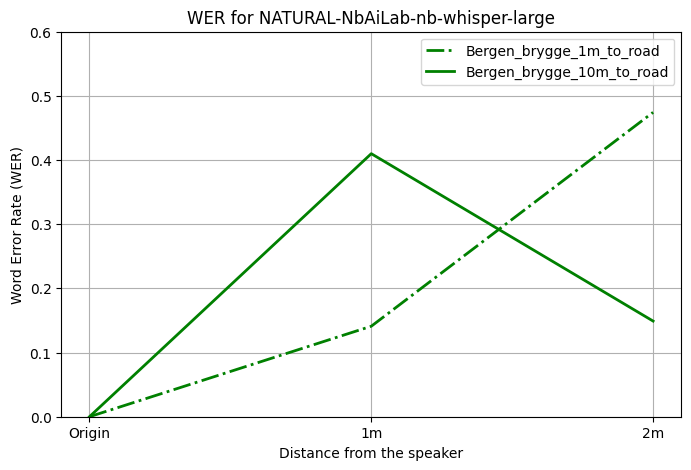

model data:  {'1m': {'Bergen_brygge_1m': 0.25949367088607594, 'Bergen_brygge_10m': 0.15568862275449102}, '2m': {'Bergen_brygge_1m': 0.3670886075949367, 'Bergen_brygge_10m': 0.1497005988023952}}


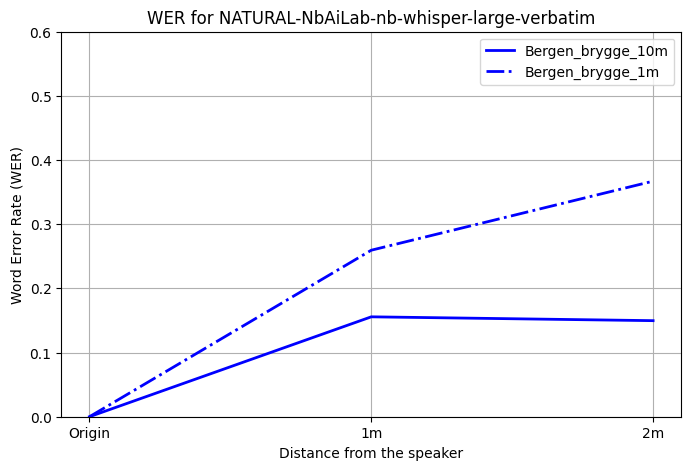

model data:  {'1m': {'Bergen_brygge_1m': 0.14102564102564102, 'Bergen_brygge_10m': 0.40993788819875776}, '2m': {'Bergen_brygge_1m': 0.47435897435897434, 'Bergen_brygge_10m': 0.453416149068323}}


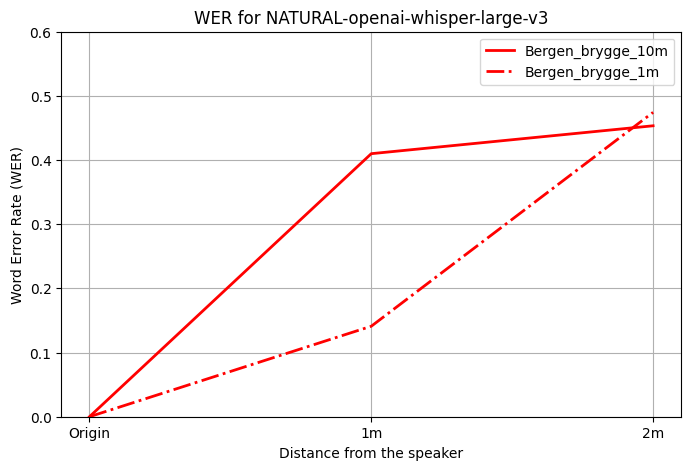

In [ ]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import re
from itertools import cycle
import werpy

def find_ground_truth_text(speaker_path):
    ground_truth_files = list(speaker_path.glob("*_0m_from_speaker_combined_transcription.txt"))
    if not ground_truth_files:
        print(f"No ground truth file found in {speaker_path}")
        return None
    return ground_truth_files[0].read_text()

def extract_text(input_text):
    # Regex to extract the text field from a structured string representation
    match = re.search(r"AutomaticSpeechRecognitionOutput\(text='([^']+)'", input_text, re.IGNORECASE)
    if match:
        return match.group(1)
    return input_text

def custom_normalize(text):
    text = extract_text(text)
    text = text.replace('chunks=None', '').strip()
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def calculate_wer(ground_truth, transcribed):
    normalized_gt = custom_normalize(ground_truth)
    normalized_transcribed = custom_normalize(transcribed)
    return werpy.wer(normalized_gt, normalized_transcribed)

def process_transcribed_files(base_path, result_path):
    result_path = Path(result_path)
    result_path.mkdir(parents=True, exist_ok=True)
    all_results = {}

    for noise_type_path in Path(base_path).iterdir():
        if noise_type_path.is_dir():
            noise_type_results = {}
            for speaker_path in noise_type_path.iterdir():
                if speaker_path.is_dir():
                    ground_truth_text = find_ground_truth_text(speaker_path)
                    if ground_truth_text is None:
                        continue
                    speaker_results = {"1m": [], "2m": []}
                    for transcribed_file in speaker_path.glob("*_from_speaker_combined_transcription.txt"):
                        distance_match = re.search(r'(\d+)m_from_speaker_combined_transcription', transcribed_file.name)
                        if distance_match:
                            distance = distance_match.group(1) + "m"
                            if distance in speaker_results:
                                transcribed_text = transcribed_file.read_text()
                                error_rate = calculate_wer(ground_truth_text, transcribed_text)
                                speaker_results[distance].append(error_rate)
                    # Store average WER for each distance in the results
                    for distance, wer_list in speaker_results.items():
                        if wer_list:  # Only calculate average if there are results
                            avg_wer = sum(wer_list) / len(wer_list)
                            if distance not in noise_type_results:
                                noise_type_results[distance] = []
                            noise_type_results[distance].append(avg_wer)
            # Calculate and store average WER for each noise type and distance
            for distance, wers in noise_type_results.items():
                averaged_distance_results = sum(wers) / len(wers) if wers else 0
                if distance not in all_results:
                    all_results[distance] = {}
                all_results[distance][noise_type_path.name] = averaged_distance_results
    return all_results




def plot_combined_wer_comparison(wer_data, model_styles, line_styles):
    plt.figure(figsize=(12, 8))
    line_cycle = cycle(line_styles)  # Cycle through different line styles for each line

    # Find all unique categories from the data to standardize x-axis across plots
    all_categories = sorted(set(cat for model_data in wer_data.values() for cat in model_data.keys()))
    category_indices = [0] + [i + 1 for i in range(len(all_categories))]  # Include origin point at 0

    # Plot data for each model
    for model_name, model_data in wer_data.items():
        color = model_styles[model_name]['color']  # Fetch color from model styles using the correct variable
        for category in all_categories:
            # Ensure all models have data for all categories, even if it's zero
            wer_scores = [0]  # Start with zero for visual clarity (origin point)
            print(f"model data {model_data}")
            if category in model_data:
                wer_scores += [model_data[category].get(location, 0) for location in sorted(model_data[category].keys())]

            plt.plot(category_indices, wer_scores, next(line_cycle), label=f"{model_name} - {category}", color=color, linewidth=2)

    plt.title("Combined WER Comparison Across Models and Categories")
    plt.xlabel("Categories")
    plt.ylabel("Word Error Rate (WER)")
    plt.xticks(ticks=category_indices, labels=["Origin"] + all_categories)  # Label categories with origin
    plt.legend()
    plt.grid(True)
    plt.ylim(0, 1.25)  # Adjust ylim to scale to your data needs
    plt.show()









def normalize_location_name(location):
    # Normalize location names to extract key parts like '1m' or '10m'
    if '1m' in location:
        return '1m'
    elif '10m' in location:
        return '10m'
    else:
        return 'unknown'

def plot_model_wer_with_auc(model_name, model_data, model_style, line_styles):
    plt.figure(figsize=(8, 5))
    color = model_style['color']

    categories = sorted(model_data.keys())
    category_indices = [0] + [i + 1 for i in range(len(categories))]

    locations = set(loc for data in model_data.values() for loc in data)
    location_data = {loc: [0] * (len(categories) + 1) for loc in locations}

    for idx, category in enumerate(categories):
        for location in locations:
            if location in model_data[category]:
                location_data[location][idx + 1] = model_data[category][location]

    for location, scores in location_data.items():
        normalized_location = normalize_location_name(location)
        # Assign line style based on normalized location
        if normalized_location == '1m':
            line_style = '-.'  # Solid line for 1m
        elif normalized_location == '10m':
            line_style = '-'  # Dotted line for 10m
        else:
            line_style = '--'  # Default line style for unknowns

        plt.plot(category_indices, scores, line_style, label=f"{location}", color=color, linewidth=2)

    plt.title(f"WER for {model_name}")
    plt.xlabel("Distance from the speaker")
    plt.ylabel("Word Error Rate (WER)")
    plt.xticks(ticks=category_indices, labels=["Origin"] + categories)
    plt.legend()
    plt.grid(True)
    plt.ylim(0, 0.6)

    plt.show()




def main():
    models = [
        {"name": "NATURAL-NbAiLab-nb-whisper-large", "path": "/content/gdrive/My Drive/Master_2024_audio/naturally_noisy_speech/transcription/COMBINED_parts_0-3/NbAiLab-nb-whisper-large"},
        {"name": "NATURAL-NbAiLab-nb-whisper-large-verbatim", "path": "/content/gdrive/My Drive/Master_2024_audio/naturally_noisy_speech/transcription/COMBINED_parts_0-3/NbAiLab-nb-whisper-large-verbatim"},
        {"name": "NATURAL-openai-whisper-large-v3", "path": "/content/gdrive/My Drive/Master_2024_audio/naturally_noisy_speech/transcription/COMBINED_parts_0-3/openai-whisper-large-v3"},
    ]

    model_styles = {
        "NATURAL-NbAiLab-nb-whisper-large": {"color": "green"},
        "NATURAL-NbAiLab-nb-whisper-large-verbatim": {"color": "blue"},
        "NATURAL-openai-whisper-large-v3": {"color": "red"},
    }

    line_styles = ['-', '-.']  # Define line styles for plotting

    wer_data = {}
    for model in models:
        base_path = Path(model["path"])
        result_path = Path(base_path.parent, "result", model["name"])
        averaged_results = process_transcribed_files(base_path, result_path)
        wer_data[model["name"]] = averaged_results

    # Plot individual models with AUC
    for model_name, model_data in wer_data.items():
        print(f"model data:  {model_data}")
        plot_model_wer_with_auc(model_name, model_data, model_styles[model_name], line_styles)

    # Plot combined comparison
    #plot_combined_wer_comparison(wer_data, model_styles, line_styles)

if __name__ == "__main__":
    main()


In [ ]:
from pathlib import Path

def count_words_in_file(file_path):
    try:
        with open(file_path, 'r', encoding='utf-8') as file:
            text = file.read()
            words = text.split()
            return len(words)
    except FileNotFoundError:
        print(f"File not found: {file_path}")
        return None

def list_and_count_words(base_path):
    results = {}  # Dictionary to hold the results
    # Define the distances we are interested in
    distances = ['0m', '1m', '2m']

    for model_dir in base_path.iterdir():
        if model_dir.is_dir():
            model = model_dir.name
            for location_dir in model_dir.iterdir():
                if location_dir.is_dir():
                    location = location_dir.name
                    for no_ent_dir in location_dir.iterdir():
                        if no_ent_dir.is_dir() and no_ent_dir.name == 'No_named_enteties':
                            for distance in distances:
                                path_pattern = f"*_{distance}_from_speaker_combined_transcription.txt"
                                for file_path in no_ent_dir.glob(path_pattern):
                                    word_count = count_words_in_file(file_path)
                                    if word_count is not None:
                                        # Initialize dictionary structure
                                        if model not in results:
                                            results[model] = {}
                                        if location not in results[model]:
                                            results[model][location] = {}
                                        results[model][location][distance] = word_count

    # Print results in a structured way
    for model, locations in results.items():
        print(f"Model: {model}")
        for location, counts in locations.items():
            print(f"  Location: {location}")
            for distance, count in counts.items():
                print(f"    Distance {distance}: {count} words")
        print()

# Example usage:
base_path = Path('/content/gdrive/My Drive/Master_2024_audio/naturally_noisy_speech/transcription/COMBINED_parts_0-3')
list_and_count_words(base_path)


Model: NbAiLab-nb-whisper-large
  Location: Bergen_brygge_1m_to_road
    Distance 0m: 78 words
    Distance 1m: 74 words
    Distance 2m: 42 words
  Location: Bergen_brygge_10m_to_road
    Distance 0m: 161 words
    Distance 1m: 103 words
    Distance 2m: 160 words

Model: NbAiLab-nb-whisper-large-verbatim
  Location: Bergen_brygge_1m
    Distance 0m: 158 words
    Distance 1m: 132 words
    Distance 2m: 124 words
  Location: Bergen_brygge_10m
    Distance 0m: 167 words
    Distance 1m: 154 words
    Distance 2m: 161 words

Model: openai-whisper-large-v3
  Location: Bergen_brygge_1m
    Distance 0m: 78 words
    Distance 1m: 74 words
    Distance 2m: 42 words
  Location: Bergen_brygge_10m
    Distance 0m: 161 words
    Distance 1m: 103 words
    Distance 2m: 110 words

